In [1]:
%load_ext cudf.pandas

In [2]:
!pip install -q lightning scikit-learn==1.4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [3]:
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning import seed_everything
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import torch.optim as optim
import lightning as L
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib
import warnings
import torch
import gc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    StandardScaler, 
    FunctionTransformer,
    OneHotEncoder,
    TargetEncoder
)

SEED = 90
seed_everything(SEED)
matplotlib.style.use("ggplot")
warnings.filterwarnings('ignore')

INFO: Seed set to 90


In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv", index_col="id")
test = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv", index_col="id")

In [5]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/518760

X = train.drop("Response", axis=1)
y = train["Response"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

ohe_columns = [
    'Gender',
#     'Region_Code',
    'Vehicle_Age',
    'Vehicle_Damage',
#     'Policy_Sales_Channel',
#     'Vintage'
]
pipeline = make_pipeline(
    ColumnTransformer([
        ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=True, dtype=np.float32, max_categories=200, handle_unknown='ignore'), ohe_columns),
        ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), ['Annual_Premium']),
    ],
    remainder=make_pipeline(FunctionTransformer(lambda X: X.astype(np.float32)), StandardScaler(copy=False)))
)

pipeline.fit(X_train, y_train)
X_train = pd.DataFrame(pipeline.transform(X_train))
X_val = pd.DataFrame(pipeline.transform(X_val))
X_test = pd.DataFrame(pipeline.transform(test))

del train, test, pipeline
gc.collect()

1767

In [6]:
X_train.shape, X_val.shape, X_test.shape

((9203838, 11), (2300960, 11), (7669866, 11))

In [7]:
def reduce_mem_usage(dataframe):
    # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
    dataframe = dataframe.copy()
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        if col_type.name in ['category', 'object']:
            raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))
    print(f'Dataset size: {dataframe.shape}\n\n')

    return dataframe

X_train = reduce_mem_usage(X_train)
X_val = reduce_mem_usage(X_val)
X_test = reduce_mem_usage(X_test)

Memory usage before: 386.21 MB
Memory usage after: 193.10 MB
Decreased memory usage by 50.0%
Dataset size: (9203838, 11)


Memory usage before: 96.55 MB
Memory usage after: 48.28 MB
Decreased memory usage by 50.0%
Dataset size: (2300960, 11)


Memory usage before: 321.84 MB
Memory usage after: 160.92 MB
Decreased memory usage by 50.0%
Dataset size: (7669866, 11)




In [8]:
class DM(L.LightningDataModule):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, batch_size):
        super(DM, self).__init__()
        self.X_train = torch.tensor(X_train.values, dtype=torch.float32)
        self.y_train = torch.tensor(y_train.values, dtype=torch.float32)
        self.X_val = torch.tensor(X_val.values, dtype=torch.float32)
        self.y_val = torch.tensor(y_val.values, dtype=torch.float32)
        self.X_test = torch.tensor(X_test.values, dtype=torch.float32)
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(
            dataset=TensorDataset(self.X_train, self.y_train),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=TensorDataset(self.X_val, self.y_val),
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4
        )
    
    def predict_dataloader(self):
        return DataLoader(
            dataset=TensorDataset(self.X_test),
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4
        )

In [9]:
class MLPModel(L.LightningModule):
    def __init__(self, input_dim, output_dim, batch_size, learning_rate):
        super(MLPModel, self).__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.classifier = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            
            # Layer 2
            nn.Linear(256, 128),
            nn.ReLU(),
            
            # Layer 3
            nn.Linear(128, 64),
            nn.ReLU(),
            
            # Output Layer
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

        self.histories = {
            "train": {
                "epoch": [],
                "loss": [],
                "auc": []
            },
            "val": {
                "epoch": [],
                "loss": [],
                "auc": []
            }
        }

        self.criterion = nn.BCELoss()
        
        self.current_epoch_train_aucs = []
        self.current_epoch_train_losses = []
        self.current_epoch_val_aucs = []
        self.current_epoch_val_losses = []

    def forward(self, x):
        return self.classifier(x)

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y)
        auc = roc_auc_score(y.cpu().numpy(), y_hat.cpu().detach().numpy())
        return loss, auc

    def log_metrics(self, history_type, loss, auc):
        if history_type == "train":
            self.current_epoch_train_aucs.append(auc)
            self.current_epoch_train_losses.append(loss)
        else:
            self.current_epoch_val_aucs.append(auc)
            self.current_epoch_val_losses.append(loss)
        self.log_dict(
            {
                f"{history_type}_loss": loss,
                f"{history_type}_auc": auc
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True
        )

    def training_step(self, batch, batch_idx):
        loss, auc = self.shared_step(batch, batch_idx)
        self.log_metrics("train", loss.item(), auc)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, auc = self.shared_step(batch, batch_idx)
        self.log_metrics("val", loss.item(), auc)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch[0])
    
    def on_train_epoch_end(self):
        epoch_auc = np.mean(self.current_epoch_train_aucs)
        epoch_loss = np.mean(self.current_epoch_train_losses)
        self.histories["train"]["epoch"].append(self.current_epoch)
        self.histories["train"]["auc"].append(epoch_auc)
        self.histories["train"]["loss"].append(epoch_loss)
        
        self.current_epoch_train_aucs = []
        self.current_epoch_train_losses = []
        
    def on_validation_epoch_end(self):        
        epoch_auc = np.mean(self.current_epoch_val_aucs)
        epoch_loss = np.mean(self.current_epoch_val_losses)
        self.histories["val"]["epoch"].append(self.current_epoch)
        self.histories["val"]["auc"].append(epoch_auc)
        self.histories["val"]["loss"].append(epoch_loss)
        
        self.current_epoch_val_aucs = []
        self.current_epoch_val_losses = []       

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode="max", 
            factor=0.5, 
            patience=3, 
            verbose=True
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_auc"
            }
        }

In [10]:
BATCH_SIZE = 2048
LEARNING_RATE = 0.005
MAX_EPOCHS = 100

data_module = DM(X_train, y_train, X_val, y_val, X_test, BATCH_SIZE)
model = MLPModel(X_train.shape[1], 1, BATCH_SIZE, LEARNING_RATE)

In [11]:
early_stopping = EarlyStopping(
    monitor="val_auc", 
    patience=3, 
    mode="max",                  
    verbose=True, 
    check_on_train_epoch_end=True, 
    min_delta=0.0001
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_auc',
    dirpath=f'./checkpoints/{datetime.now().strftime("%Y%m%d-%H%M%S")}',
    filename='{epoch}-{val_auc:.5f}',
    auto_insert_metric_name=False,
    save_top_k=1,
    every_n_epochs=1,
    mode='max',
    save_on_train_epoch_end=True
)

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stopping, checkpoint_callback]
)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, data_module)
trainer.validate(model, data_module)

2024-07-09 09:33:09.536922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 09:33:09.537057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 09:33:09.665070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 44.3 K | train
1 | criterion  | BCELoss    | 0      | train
--------------------------------------------------
44.3 K    Trainable params
0         Non-trainable params
44.3 K    Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_auc improved. New best score: 0.873


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_auc improved by 0.000 >= min_delta = 0.0001. New best score: 0.873


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_auc improved by 0.001 >= min_delta = 0.0001. New best score: 0.874


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_auc improved by 0.000 >= min_delta = 0.0001. New best score: 0.874


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_auc improved by 0.001 >= min_delta = 0.0001. New best score: 0.875


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_auc did not improve in the last 3 records. Best score: 0.875. Signaling Trainer to stop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_auc_epoch       │    0.8745378255844116     │
│      val_loss_epoch       │    0.2565855383872986     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.2565855383872986, 'val_auc_epoch': 0.8745378255844116}]

In [13]:
preds = trainer.predict(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

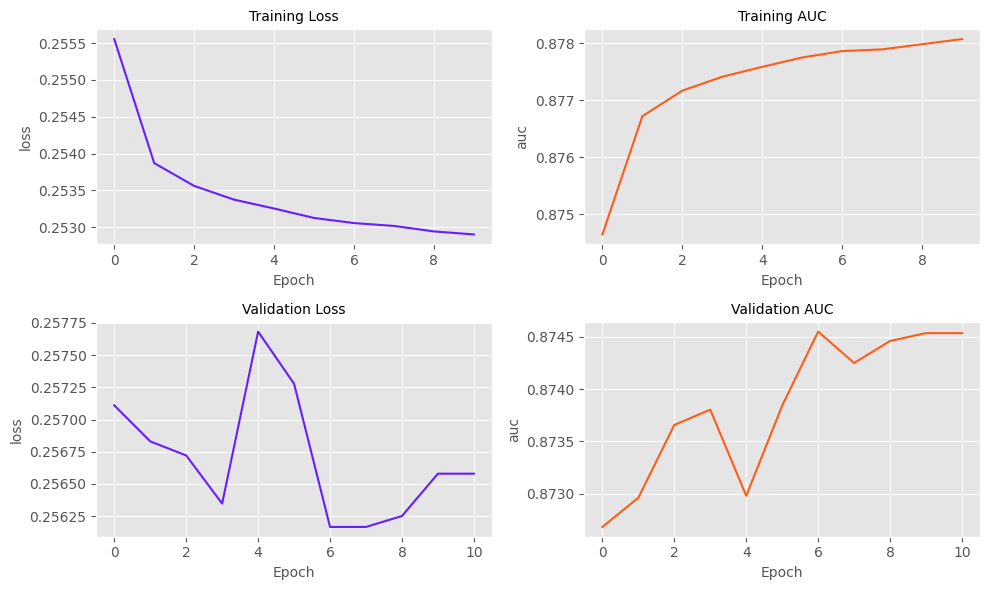

In [14]:
histories = model.histories

if histories["val"]["epoch"][0] == histories["val"]["epoch"][1]:
    histories["val"]["epoch"] = histories["val"]["epoch"][1:]
    histories["val"]["auc"] = histories["val"]["auc"][1:]
    histories["val"]["loss"] = histories["val"]["loss"][1:]

def plot_metric(ax, history, metric, title, color):
    steps = history["epoch"]
    values = pd.Series(history[metric])
    ax.plot(steps, values, color=color)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

plot_metric(ax[0, 0], histories["train"], "loss", "Training Loss", '#651fff')
plot_metric(ax[0, 1], histories["train"], "auc", "Training AUC", '#ff5c19')
plot_metric(ax[1, 0], histories["val"], "loss", "Validation Loss", '#651fff')
plot_metric(ax[1, 1], histories["val"], "auc", "Validation AUC", '#ff5c19')

plt.tight_layout()
plt.show()

In [15]:
y_hat = []
for pred in preds:
    for p in pred.squeeze():
        y_hat.append(p.cpu().detach().numpy().item())

submission = pd.read_csv("/kaggle/input/playground-series-s4e7/sample_submission.csv")
submission["Response"] = y_hat
submission.to_csv("submission.csv", index=False)
submission.head()

,id,Response
0,11504798,0.014410
1,11504799,0.481458
2,11504800,0.274341
3,11504801,0.000005
4,11504802,0.059072
